In [ ]:
# Universal Basic Income Program in Colombia
# Jairo Fernando Gudiño-Rosero.

# In this code, a RCT is evaluated using fashion algorithms of Machine Learning to detect
# revelant patterns for the final identification.

In [17]:
!pip install mca
import mca
!pip install linearmodels
import linearmodels

In [156]:

%matplotlib inline

# Import Basic Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
# Import Metrics Libraries
from sklearn.metrics import mean_squared_error
# Import Linear Model Libraries
from linearmodels.system import SUR

#alphas = 10**np.linspace(10,-2,100)*0.5

# Function to define control variables, following Belloni, Chernozhukov & Hansen (2014)'s meth.
def sur_specifications(df, controls, outcomes):
  sur_specifications = {}
  for o in outcomes:
        df_o = df[[o]+['treat']+controls+[o[:-1] + "0"]].dropna() #
        y_treat = df_o[['treat']]
        y_outcome = df_o[o]
        if (o == 'asset_total_ppp1' or o == 'ent_total_rev_ppp1' or o in consumption_outcomes_t1):
                  y_outcome = (y_outcome - y_outcome.mean())/y_outcome.std()
        X_controls = df_o[controls + [o[:-1] + "0"]] #
        X_controls = StandardScaler().fit(X_controls).transform(X_controls)
        
        lassocv_outcome = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = False)
        lassocv_outcome.fit(X_controls,y_outcome.values.ravel())
        lasso_outcome = Lasso(max_iter = 10000, normalize = False)
        lasso_outcome.set_params(alpha=lassocv_outcome.alpha_)
        lasso_outcome.fit(X_controls,y_outcome.values.ravel())  
        lasso_coef = pd.DataFrame(lasso_outcome.coef_, index= controls + [o[:-1] + "0"], columns = ['Coefficients'])
        lasso_outcomes_var = lasso_coef[lasso_coef['Coefficients'] != 0].index.to_list()
        
        lassocv_treat = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = False)
        lassocv_treat.fit(X_controls,y_treat.values.ravel())
        lasso_treat = Lasso(max_iter = 10000, normalize = False) 
        lasso_treat.set_params(alpha=lassocv_treat.alpha_)
        lasso_treat.fit(X_controls,y_treat.values.ravel()) 
        lasso_coef_treat = pd.DataFrame(lasso_treat.coef_, index= controls + [o[:-1] + "0"], columns = ['Coefficients'])
        lasso_treat_var = lasso_coef_treat[lasso_coef_treat['Coefficients'] != 0].index.to_list()

        lasso_variables = list(dict.fromkeys(lasso_outcomes_var + lasso_treat_var))
        #sur_specifications[o] = o + " ~ 1 + treat + " + o[:-1] + "0 " + " + " + " + ".join(lasso_variables)
        sur_specifications[o] = o + " ~ 1 + treat + " + " + ".join(lasso_variables) #
  return sur_specifications

In [95]:
# Define outcome & control variables
# t = 1 (9 months after)
outcomes_t1 = ['asset_total_ppp1','ent_total_rev_ppp1',
            'fs_hhfoodindexnew1','med_hh_healthindex1','ed_index1']
consumption_outcomes_t1 = ['cons_allfood_ppp_m1','cons_meatfish_ppp_m1',
                        'cons_cereals_ppp_m1','cons_alcohol_ppp_m1',
                        'cons_med_total_ppp_m1','cons_ed_ppp_m1']

# t = 0 (baseline survey)
outcomes_t0 = ['asset_total_ppp0','ent_total_rev_ppp0',
            'fs_hhfoodindexnew0','med_hh_healthindex0','ed_index0']
consumption_outcomes_t0 = ['cons_allfood_ppp_m0','cons_meatfish_ppp_m0',
                        'cons_cereals_ppp_m0','cons_alcohol_ppp_m0',
                        'cons_med_total_ppp_m0','cons_ed_ppp_m0']

# Define control variables
controls = ['cons_total_ppp0','b_age','b_edu','b_children','b_hhsize',
            'b_married','ent_wagelabor0','ent_business0','ent_nonagbusiness0','ent_ownfarm0']

# Set list of some variables to log-units before running the SUR regression
log_vars = ['asset_total_ppp0','asset_total_ppp1','ent_total_rev_ppp0','ent_total_rev_ppp1','cons_total_ppp0']


In [159]:
# Read .dta file containing information about the RCT experiment
filename_db = 'UCT_Choco.dta'
df = pd.read_stata(filename_db)
# Given the database is composed by individuals, we select households only.
df = df[df['include'] == 1]
df = df[outcomes_t0 + outcomes_t1 + ['treat','attrition'] + controls].dropna()
df 

,asset_total_ppp0,ent_total_rev_ppp0,fs_hhfoodindexnew0,med_hh_healthindex0,ed_index0,asset_total_ppp1,ent_total_rev_ppp1,fs_hhfoodindexnew1,med_hh_healthindex1,ed_index1,treat,attrition,cons_total_ppp0,b_age,b_edu,b_children,b_hhsize,b_married,ent_wagelabor0,ent_business0,ent_nonagbusiness0,ent_ownfarm0
1,2969281.50,3.381368e+05,-1.148793,-0.798766,1.123388,3408360.0,5.949619e+05,0.438831,0.912099,2.335604,0.0,0.0,4.562351e+05,71.0,17.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0
3,7526812.00,6.739648e+05,0.184116,1.137442,0.316027,8063439.0,1.127314e+06,0.638313,0.441287,2.312059,1.0,0.0,1.062828e+06,40.0,7.0,4.0,6.0,1.0,1.0,0.0,0.0,0.0
5,12486722.00,1.142646e+06,-1.094900,-0.771171,-0.398159,14972911.0,9.047331e+05,0.418508,1.062344,0.419057,0.0,0.0,1.097371e+06,27.0,9.0,3.0,5.0,1.0,0.0,0.0,1.0,1.0
7,4547198.00,1.851939e+06,0.166111,0.058097,-1.021486,2932214.0,1.605725e+06,0.499703,0.987169,0.283439,0.0,0.0,9.280017e+05,24.0,12.0,2.0,4.0,1.0,0.0,1.0,1.0,0.0
13,4808683.00,1.063869e+06,0.478965,2.156636,0.366845,5104558.5,5.943507e+05,-0.285357,-0.957455,-1.604174,0.0,0.0,1.543331e+06,22.0,8.0,3.0,7.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,4524226.50,6.854457e+05,-1.062685,0.013361,-0.482334,8824858.0,4.344096e+05,-2.071967,0.120822,1.064054,1.0,0.0,1.054858e+06,49.0,4.0,2.0,5.0,0.0,0.0,0.0,1.0,1.0
2009,774571.75,4.297862e+05,0.962045,0.129124,0.450933,11188877.0,1.342536e+06,1.670554,0.116520,0.642667,1.0,0.0,5.576781e+05,33.0,7.0,5.0,8.0,0.0,0.0,0.0,1.0,1.0
2011,12119571.00,9.574285e+05,-0.226511,0.474630,0.331748,11504275.0,4.191515e+05,-0.205984,-0.971975,0.234361,1.0,0.0,1.958644e+06,36.0,10.0,7.0,10.0,0.0,0.0,1.0,1.0,0.0
2013,5318698.50,7.970064e+05,0.107568,1.001005,-0.088777,7312438.5,1.118762e+06,0.758219,1.796330,4.148555,1.0,0.0,1.159894e+06,40.0,10.0,6.0,8.0,0.0,0.0,0.0,1.0,1.0


In [160]:
# Identify relevant variables through LASSO regressions:
sur_specifications_main = sur_specifications(df, controls, outcomes_t1)
print(sur_specifications_main)

{'asset_total_ppp1': 'asset_total_ppp1 ~ 1 + treat + ent_nonagbusiness0 + asset_total_ppp0', 'ent_total_rev_ppp1': 'ent_total_rev_ppp1 ~ 1 + treat + cons_total_ppp0 + b_edu + b_hhsize + b_married + ent_business0 + ent_total_rev_ppp0', 'fs_hhfoodindexnew1': 'fs_hhfoodindexnew1 ~ 1 + treat + b_married + fs_hhfoodindexnew0', 'med_hh_healthindex1': 'med_hh_healthindex1 ~ 1 + treat + b_age + b_edu + b_hhsize + ent_business0 + med_hh_healthindex0', 'ed_index1': 'ed_index1 ~ 1 + treat + b_age + b_edu + b_hhsize + ent_wagelabor0 + ent_business0 + ent_nonagbusiness0 + ent_ownfarm0 + ed_index0'}


In [161]:
# To solve unit problems, we express some variables in log-terms to understand more
# deeply the impact of the program.
df[log_vars] = np.log(df[log_vars])
#df[log_vars] = StandardScaler().fit(df[log_vars]).transform(df[log_vars])

In [162]:
# Baseline Differences:
# Means & Variances in t=0:
df[outcomes_t0][df['treat'] == 0].describe()

,asset_total_ppp0,ent_total_rev_ppp0,fs_hhfoodindexnew0,med_hh_healthindex0,ed_index0
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,15.608893,13.401211,0.036356,0.079668,0.028142
std,0.685325,0.563621,0.994231,0.936530,0.968659
min,13.107190,11.364434,-4.873898,-3.730426,-1.664937
25%,15.195320,13.080437,-0.504635,-0.556189,-0.516065
50%,15.596504,13.399162,0.067467,0.013023,-0.033898
75%,16.093231,13.767178,0.770652,0.525126,0.393899
max,17.693121,15.274676,2.755445,2.288912,3.603603


In [163]:
df[outcomes_t0][df['treat'] == 1].describe()

,asset_total_ppp0,ent_total_rev_ppp0,fs_hhfoodindexnew0,med_hh_healthindex0,ed_index0
count,387.000000,387.000000,387.000000,387.000000,387.000000
mean,15.533493,13.343871,0.010039,0.089807,-0.049799
std,0.747733,0.543962,0.926136,0.970047,0.794101
min,12.078150,11.364434,-5.045101,-2.697428,-1.664937
25%,15.065955,12.997717,-0.493666,-0.596653,-0.444311
50%,15.554334,13.350626,0.132328,-0.018737,-0.012603
75%,16.011287,13.734769,0.652284,0.616885,0.396093
max,17.822195,14.827991,1.828638,2.156636,3.203882


In [164]:
# T-tests
for o in outcomes_t0:
    _,pvalue = stats.ttest_ind(df[o][df['treat'] == 0],df[o][df['treat'] == 1], equal_var = False)
    print("The p-value of t-test for " + o + " is: " + str(pvalue))

The p-value of t-test for asset_total_ppp0 is: 0.14935997302334644
The p-value of t-test for ent_total_rev_ppp0 is: 0.15625020178536492
The p-value of t-test for fs_hhfoodindexnew0 is: 0.7075468728605772
The p-value of t-test for med_hh_healthindex0 is: 0.8840149155196411
The p-value of t-test for ed_index0 is: 0.22912941009207702


In [165]:
# We fit a SUR-model to quantify the impact of the program in financial & social variables:
SUR_model = SUR.from_formula(sur_specifications_main, df)
SUR_model .  fit ( cov_type = 'unadjusted' )

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


System GLS Estimation Summary                           
===================================================================================
Estimator:                        GLS   Overall R-squared:                   0.1607
No. Equations.:                     5   McElroy's R-squared:                 0.1603
No. Observations:                 753   Judge's (OLS) R-squared:             0.1607
Date:                Sun, Nov 22 2020   Berndt's R-squared:                  0.5566
Time:                        03:49:07   Dhrymes's R-squared:                 0.1607
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
           Equation: asset_total_ppp1, Dependent Variable: asset_total_ppp1           
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              8.9512     0.4900     18.267     0.0000      7.9907      9.9116
treat                  0.4995     0.0466     10.728     0.0000      0.4083      0.5908
ent_nonagbusiness0    -0.1030     0.0463    -2.2214     0.0263     -0.1938     -0.0121
asset_total_ppp0       0.4152     0.0314     13.218     0.0000      0.3536      0.4767
         Equation: ent_total_rev_ppp1, Dependent Variable: ent_total_rev_ppp1         
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              9.2958     0.5607     16.579     0.0000      8.1968      10.395
treat                  0.1157     0.0374     3.0926     0.0020      0.0424      0.1891
cons_total_ppp0        0.0640     0.0426     1.5023     0.1330     -0.0195      0.1476
b_edu                  0.0146     0.0066     2.1951     0.0282      0.0016      0.0276
b_hhsize               0.0364     0.0097     3.7647     0.0002      0.0175      0.0554
b_married              0.0369     0.0488     0.7570     0.4490     -0.0587      0.1325
ent_business0          0.1034     0.0521     1.9835     0.0473      0.0012      0.2055
ent_total_rev_ppp0     0.2051     0.0385     5.3199     0.0000      0.1295      0.2806
         Equation: fs_hhfoodindexnew1, Dependent Variable: fs_hhfoodindexnew1         
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.1547     0.0840    -1.8416     0.0655     -0.3194      0.0099
treat                  0.3057     0.0652     4.6869     0.0000      0.1779      0.4335
b_married              0.2138     0.0842     2.5386     0.0111      0.0487      0.3788
fs_hhfoodindexnew0     0.1440     0.0327     4.4092     0.0000      0.0800      0.2081
         Equation: med_hh_healthindex1, Dependent Variable: med_hh_healthindex1        
=======================================================================================
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
Intercept              -0.2568     0.1641    -1.5651     0.1176     -0.5784      0.0648
treat                   0.0616     0.0572     1.0775     0.2812     -0.0505      0.1737
b_age                  -0.0050     0.0026    -1.9160     0.0554     -0.0100      0.0001
b_edu                   0.0204     0.0110     1.8627     0.0625     -0.0011      0.0419
b_hhsize                0.0298     0.0153     1.9485     0.0514     -0.0002      0.0598
ent_business0           0.1446     0.0775  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Text(0.5, 0, 'Relative Importance')

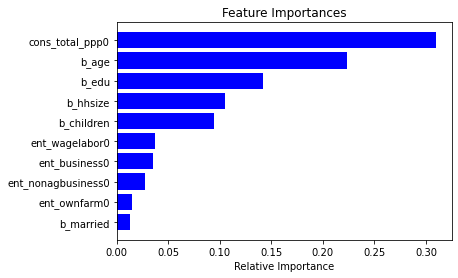

In [127]:
# Fit Decision-Tree & Random Forests Classifiers to identify compliance problems:
# We use ML-classifiers, with treatment variable as dependent variable, to identify
# systematic patterns in the data signaling compliance problems.

y_treat = df[['treat']]
X_controls = df[controls]
forest = RandomForestClassifier(max_depth=4, random_state=0)
forest.fit(X_controls, y_treat)

importances = forest.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [controls[i] for i in tuple(indices)])
plt.xlabel('Relative Importance')

[Text(813.75, 1321.25, 'cons_total_ppp0 <= 13.906\ngini = 0.5\nsamples = 753\nvalue = [366, 387]\nclass = Treatment'),
 Text(406.875, 792.75, 'ent_business0 <= 0.5\ngini = 0.49\nsamples = 375\nvalue = [161, 214]\nclass = Treatment'),
 Text(203.4375, 264.25, 'gini = 0.482\nsamples = 316\nvalue = [128, 188]\nclass = Treatment'),
 Text(610.3125, 264.25, 'gini = 0.493\nsamples = 59\nvalue = [33, 26]\nclass = Control'),
 Text(1220.625, 792.75, 'b_age <= 21.85\ngini = 0.496\nsamples = 378\nvalue = [205, 173]\nclass = Control'),
 Text(1017.1875, 264.25, 'gini = 0.332\nsamples = 19\nvalue = [4, 15]\nclass = Treatment'),
 Text(1424.0625, 264.25, 'gini = 0.493\nsamples = 359\nvalue = [201, 158]\nclass = Control')]

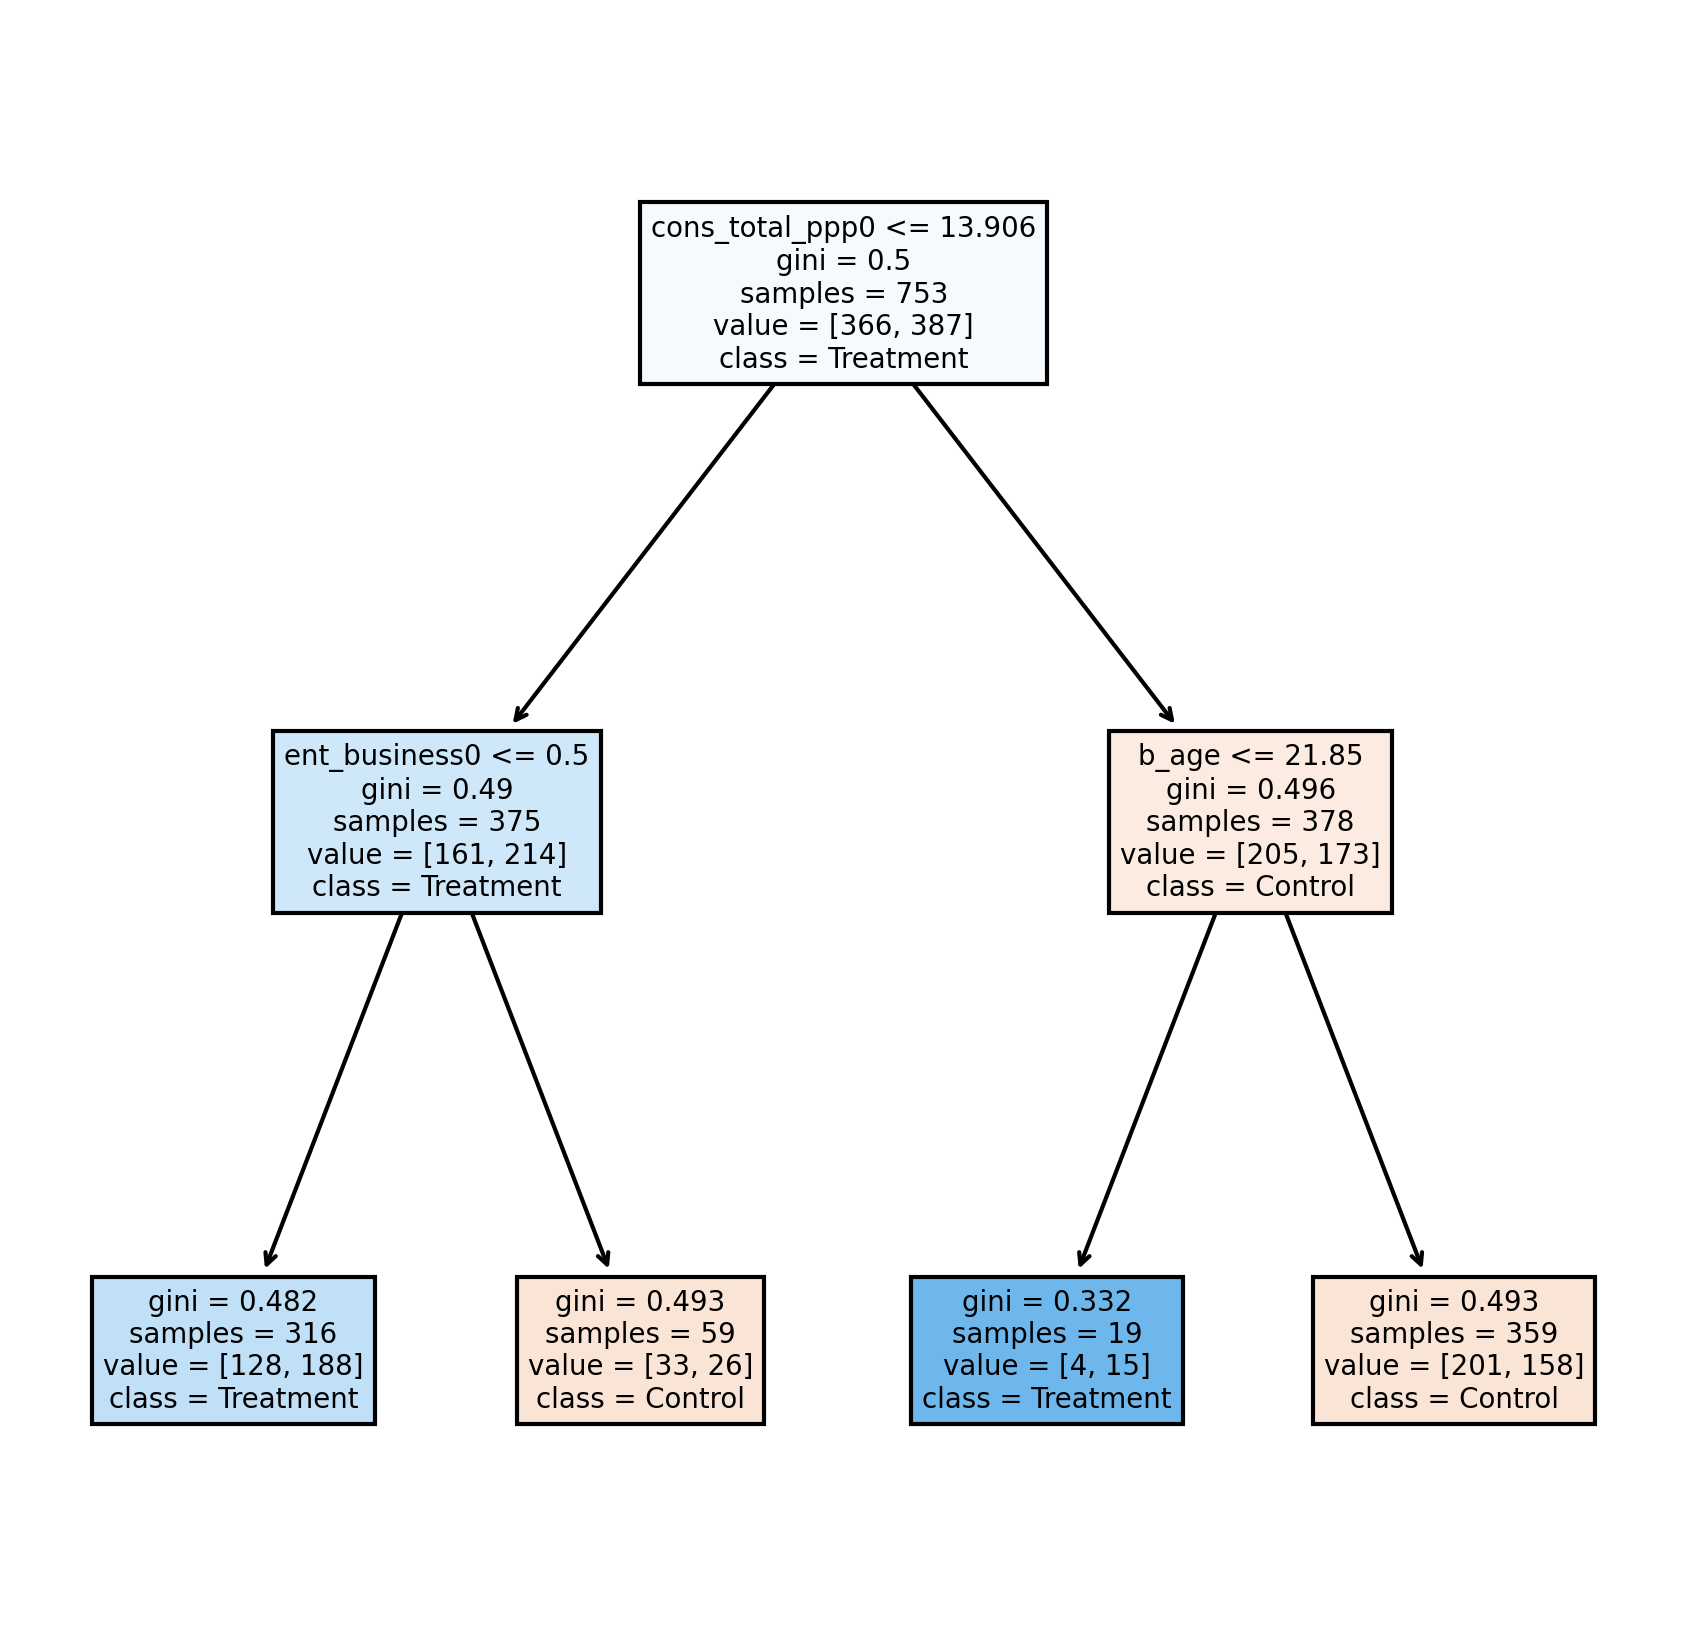

In [128]:
# Some variables are important to explain differences between treatment and control
# groups, so I use decision-trees to understand these differences. 

y_treat = df[['treat']]
X_controls = df[controls]
dt = DecisionTreeClassifier(random_state=0, max_depth=2)
dt.fit(X_controls, y_treat)
# Predict
pscore_tree = dt.predict(X_controls)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (7,7), dpi=300)
tree.plot_tree(dt,filled=True,feature_names=controls,class_names= ['Control','Treatment'])

In [ ]:
# Although we find relevant patterns to predict treatment - which signal a compliance problem -,
# the number of households in subsets where mismatch between treatment and control arises is too
# low, which means the compliance problem is not important in this case.

In [ ]:
# Attrition Problems.
# The database is read again to understand quantitatively attrition patterns:

In [129]:
df = pd.read_stata(filename_db)
# Given the database is composed by individuals, we select households only.
df = df[df['include'] == 1]
# I analyze if attrition follows baseline differences.
df = df[outcomes_t0 + ['attrition']].dropna()
df

,asset_total_ppp0,ent_total_rev_ppp0,fs_hhfoodindexnew0,med_hh_healthindex0,ed_index0,attrition
1,2969281.50,3.381368e+05,-1.148793,-0.798766,1.123388,0.0
3,7526812.00,6.739648e+05,0.184116,1.137442,0.316027,0.0
5,12486722.00,1.142646e+06,-1.094900,-0.771171,-0.398159,0.0
7,4547198.00,1.851939e+06,0.166111,0.058097,-1.021486,0.0
11,10096264.00,4.507107e+05,-0.551835,-0.445003,-0.250780,1.0
...,...,...,...,...,...,...
2007,4524226.50,6.854457e+05,-1.062685,0.013361,-0.482334,0.0
2009,774571.75,4.297862e+05,0.962045,0.129124,0.450933,0.0
2011,12119571.00,9.574285e+05,-0.226511,0.474630,0.331748,0.0
2013,5318698.50,7.970064e+05,0.107568,1.001005,-0.088777,0.0


In [130]:
# I run LASSO regressions to understand if attrition follow systematic patterns:
attr_specifications = {}
for o in outcomes_t0:

        y_treat = df[['attrition']]
        y_outcome = df[o]
        if (o == 'asset_total_ppp1' or o == 'ent_total_rev_ppp1' or o in consumption_outcomes_t1):
                  y_outcome = (y_outcome - y_outcome.mean())/y_outcome.std()

        lasso = Lasso(max_iter = 30000, normalize = False)
        coefs = []
        for a in alphas:
              lasso.set_params(alpha=a)
              lasso.fit(y_treat,y_outcome)
              coefs.append(lasso.coef_)  
        lasso_coef = pd.DataFrame(lasso.coef_, index=['attr'], columns = ['Coefficients'])
        lasso_outcomes_var = lasso_coef[lasso_coef['Coefficients'] != 0].index.to_list()

        lasso_variables = list(dict.fromkeys(lasso_outcomes_var))
        attr_specifications[o] = o + " ~ 1 + " + " + ".join(lasso_variables)

attr_specifications

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5476083302400.0, tolerance: 2644991279104.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5725191405568.0, tolerance: 2644991279104.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16694537879552.0, tolerance: 2644991279104.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32506459979776.0, toler

{'asset_total_ppp0': 'asset_total_ppp0 ~ 1 + attr',
 'ed_index0': 'ed_index0 ~ 1 + attr',
 'ent_total_rev_ppp0': 'ent_total_rev_ppp0 ~ 1 + attr',
 'fs_hhfoodindexnew0': 'fs_hhfoodindexnew0 ~ 1 + ',
 'med_hh_healthindex0': 'med_hh_healthindex0 ~ 1 + attr'}

In [ ]:
# This result strikes with the found by Haushofer & Shapiro (2016) using the same database,
# but with different units, because they do not find conclusive evidence.

# Given this, let's assume they exist. I would use ML-algorithms to solve the methodology proposed in class to solve it.
# (i) I calculate 2 probabilities of no attrition: one with relevant and another with irrelevant variables detected
# (ii) With the resulting ratio of both , I use it to give more weights to HHs with lower attrition propensity
# to the non-attrition households.

#  However, only 5.39% of the sample - which was excluded in the above estimations -,
# register this problem, so we can be sure results will not be too affected.
df[['attrition']].sum()/df.shape[0]*100


attrition    5.395683
dtype: float32